In [1]:
import nltk
import re
#nltk.download('stopwords')
import pickle
#from nltk.corpus import stopwords

In [2]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [3]:
from sklearn.datasets import load_files
my_data=load_files(r'C:\ML Training Docs\New folder\data_final3')
X,y = my_data.data, my_data.target

In [4]:
import pandas as pd
import numpy as np
df=pd.DataFrame({'filenames':[my_data.filenames],'target':[my_data.target]})
df=explode(df,['filenames','target'],fill_value='',preserve_index=True)
df['target']=df['target'].replace([0,1,2,3,4],['3rd Party Expert','GMC','Solicitor Contacts','MDU Invoices','NHSLA'])
# df.to_csv(r'C:\ML Training Docs\New folder\data_final\data_final.csv',index=False)
df.head()

,filenames,target
0,C:\ML Training Docs\New folder\data_final3\3rd...,3rd Party Expert
0,C:\ML Training Docs\New folder\data_final3\GMC...,GMC
0,C:\ML Training Docs\New folder\data_final3\3rd...,3rd Party Expert
0,C:\ML Training Docs\New folder\data_final3\NHS...,NHSLA
0,C:\ML Training Docs\New folder\data_final3\GMC...,GMC


In [5]:

import re
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    
    #Remove \n from text
    document = re.sub(r'\\n', ' ', str(X[sen]))
    
    # remove \t from text
    document = re.sub(r'\\t', ' ', document)
    
     # Remove \\ from the text
    document = re.sub(r'\\', ' ', document)
    
     # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    
    #Remove special character
    document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)
    
   

    
    # Remove one char joins with 2 digit number
    document= re.sub(r'[A-Za-z]{1}[0-9]{2}', ' ', document)
    #Remove 1 digit number joins with 2 char
    document = re.sub(r'[0-9]{1}[A-Za-z]{2}',' ',document)
     #Remove one char in between two numbers
    document = re.sub(r'[0-9]{1}[A-Za-z]{1}[0-9]{1}',' ',document)
    #Remove one number in between two char
    document = re.sub(r'[A-Za-z]{1}[0-9]{1}[A-Za-z]{1}',' ',document)
    
    # Remove two char joins with 2 digit number
    document= re.sub(r'[A-Za-z]{2}[0-9]{2}', ' ', document)
    
    # Remove two char joins with 1 digit number
    document= re.sub(r'[A-Za-z]{2}[0-9]{1}', ' ', document)
    
   
    # Remove double digit number
    document=re.sub('(\\b[0-9][0-9] \\b|\\b [0-9][0-9]\\b)', ' ', document).strip()
    #Remove single character
    document=re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', ' ', document).strip()
    # Remove single digit number
    document=re.sub('(\\b[0-9] \\b|\\b [0-9]\\b)', ' ', document).strip()

    # Substituting multiple spaces with single space
    document = re.sub(r' +', ' ', document)

    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
#     document = ' '.join(e for e in document if e.isalnum())
    document = ' '.join([w for w in document.split() if len(w)>1])
    
    
    
    documents.append(document)

In [6]:
doc_list = documents
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

clean_document = [' '.join([b for b in a.split() if b not in stop_words]) for a in doc_list]

In [10]:
clean_document[0:1]

['michael hare md frcpi frcog consultant obstetrician gynaecologist jun 2012 camlough road newry co kirsty hurrell solicitor gmc legal fitness practise directorate general medical council hardman street manchester m3 aw 2012 dear hurrell general medical council dr patrick bose enclose requested confidential medical report concerning please contact assistance sincerely michael hare michael hare md frcpi frcog consultant obstetrician gynaecologist jun 2012 camlough road newry co kirsty hurrell solicitor gmc legal fitness practise directorate general medical council hardman street manchester m3 aw 2012 dear hurrell general medical council dr patrick bose enclose requested confidential medical report concerning please contact assistance sincerely michael hare general medical council dr patrick bose conftdential medical report june 2012 prepared michael hare md frcpi frcog consultant obstetrician gynaecologist southern health social care trust daisy hill hospital newry co sdr past chairman 

In [7]:
import unidecode
accented=[]
for i in range(0,len(clean_document)):
    ach=unidecode.unidecode(clean_document[i])
    accented.append(ach)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(accented).toarray()

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,shuffle=True)

In [24]:
'''training the data in RF model'''
import time
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=RandomForestClassifier()
start = time.time()
classifier.fit(X_train,y_train)
# the time would be round to 3 decimal in seconds
end = time.time()
print ("Random_forest_training time:", round(end-start, 3), "s")
# t1=time.time()
y_pred=classifier.predict(X_test)
# print ("predict time:", round(end-t1, 3), "s")
print('RandomForest:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))
y_pred_prob = classifier.predict_proba(X_test)
print('log_loss Random Forest:', log_loss(y_test,y_pred_prob))
# print('log_loss Random Forest:', log_loss(y_test,y_pred,label=classifier.classes_))

Random_forest_training time: 1.853 s
RandomForest: 0.8372881355932204
[[115   4   4   0  10]
 [ 15 153   4   0   5]
 [  4  13  46   1   8]
 [  2   0   4 116   2]
 [ 10   8   2   0  64]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       133
           1       0.86      0.86      0.86       177
           2       0.77      0.64      0.70        72
           3       0.99      0.94      0.96       124
           4       0.72      0.76      0.74        84

    accuracy                           0.84       590
   macro avg       0.82      0.81      0.82       590
weighted avg       0.84      0.84      0.84       590

Accuracy score (training): 0.997
Accuracy score (test): 0.837
log_loss Random Forest: 0.6048575387754755


In [19]:
# Save to file in the current working directory

with open(r'C:\ML Training Docs\New folder\pickle file\Random_Forest.pkl', 'wb') as file:
    pickle.dump(classifier, file)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
GB_classifier=GradientBoostingClassifier()
start = time.time()
GB_classifier.fit(X_train,y_train)
end = time.time()
print ("Gradient_Boost_training time:", round(end-start, 3), "s")
y_pred=GB_classifier.predict(X_test)
print('GradientBoostingClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(GB_classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(GB_classifier.score(X_test, y_test)))
y_pred_prob = GB_classifier.predict_proba(X_test)
print('log_loss GradientBoostingClassifier:', log_loss(y_test,y_pred_prob))

Gradient_Boost_training time: 148.147 s
GradientBoostingClassifier: 0.8406779661016949
[[113   6   3   0  11]
 [  6 157   4   0  10]
 [  4  10  49   2   7]
 [  3   2   4 115   0]
 [ 11   7   4   0  62]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       133
           1       0.86      0.89      0.87       177
           2       0.77      0.68      0.72        72
           3       0.98      0.93      0.95       124
           4       0.69      0.74      0.71        84

    accuracy                           0.84       590
   macro avg       0.82      0.82      0.82       590
weighted avg       0.84      0.84      0.84       590

Accuracy score (training): 0.982
Accuracy score (test): 0.841
log_loss GradientBoostingClassifier: 0.4469490973951228


In [26]:
# Save to file in the current working directory

with open(r'C:\ML Training Docs\New folder\pickle file\Gradient_Boosting.pkl', 'wb') as file:
    pickle.dump(GB_classifier, file)

In [28]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier()
start = time.time()
lgbm_model.fit(X_train, y_train)
end = time.time()
y_pred = lgbm_model.predict(X_test)
print('LGBMClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(lgbm_model.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(lgbm_model.score(X_test, y_test)))
y_pred_prob = lgbm_model.predict_proba(X_test)
print('log_loss LGBMClassifier:', log_loss(y_test,y_pred_prob))

LGBMClassifier: 0.8728813559322034
[[115   3   4   0  11]
 [  6 160   4   1   6]
 [  4  10  52   1   5]
 [  3   0   4 117   0]
 [  5   5   3   0  71]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       133
           1       0.90      0.90      0.90       177
           2       0.78      0.72      0.75        72
           3       0.98      0.94      0.96       124
           4       0.76      0.85      0.80        84

    accuracy                           0.87       590
   macro avg       0.86      0.86      0.86       590
weighted avg       0.87      0.87      0.87       590

Accuracy score (training): 0.997
Accuracy score (test): 0.873
log_loss LGBMClassifier: 0.5056465352321552


In [29]:
with open(r'C:\ML Training Docs\New folder\pickle file\lgbm.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)

In [32]:
import pickle
pickle.dump(CountVectorizer,open(r'C:\ML Training Docs\New folder\pickle file\lgbm_count_vect.pkl','wb'))
pickle.dump(lgbm_model,open(r'C:\ML Training Docs\New folder\pickle file\lgbm_clf.pkl','wb'))

In [30]:
mlb = pickle.loads(open(r'C:\ML Training Docs\New folder\pickle file\lgbm.pkl','rb').read())
for (i,label) in enumerate(mlb.classes_):
    print('{}. {}'.format(i + 1, label))

1. 0
2. 1
3. 2
4. 3
5. 4


In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=MultinomialNB()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("MultinomialNB_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print(accuracy_score(y_test,y_pred))
print('MultinomialNB:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

MultinomialNB_training time: 0.198 s
0.7694915254237288
MultinomialNB: 0.7694915254237288
[[116  12   5   3   3]
 [ 28 140   1   7   4]
 [  5  11  48   4   1]
 [  0   0   3 115   0]
 [ 20  15  13   1  35]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       139
           1       0.79      0.78      0.78       180
           2       0.69      0.70      0.69        69
           3       0.88      0.97      0.93       118
           4       0.81      0.42      0.55        84

    accuracy                           0.77       590
   macro avg       0.77      0.74      0.74       590
weighted avg       0.77      0.77      0.76       590

Accuracy score (training): 0.784
Accuracy score (test): 0.769


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=LogisticRegression()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("Logistic_Regression_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('LogisticRegression:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

Logistic_Regression_training time: 0.818 s
LogisticRegression: 0.8355932203389831
[[117   6   5   3   8]
 [ 19 149   5   0   7]
 [  5   5  54   2   3]
 [  0   0   4 114   0]
 [ 10   7   8   0  59]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       139
           1       0.89      0.83      0.86       180
           2       0.71      0.78      0.74        69
           3       0.96      0.97      0.96       118
           4       0.77      0.70      0.73        84

    accuracy                           0.84       590
   macro avg       0.82      0.82      0.82       590
weighted avg       0.84      0.84      0.84       590

Accuracy score (training): 0.899
Accuracy score (test): 0.836


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=SVC()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("SVC_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('SVC:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

SVC_training time: 4.679 s
SVC: 0.8559322033898306
[[119   4   7   3   6]
 [ 20 148   4   1   7]
 [  6   3  57   2   1]
 [  0   1   3 113   1]
 [  9   2   5   0  68]]
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       139
           1       0.94      0.82      0.88       180
           2       0.75      0.83      0.79        69
           3       0.95      0.96      0.95       118
           4       0.82      0.81      0.81        84

    accuracy                           0.86       590
   macro avg       0.85      0.85      0.85       590
weighted avg       0.86      0.86      0.86       590

Accuracy score (training): 0.960
Accuracy score (test): 0.856


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=DecisionTreeClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("Decision_tree_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

Decision_tree_training time: 1.053 s
0.7457627118644068
[[ 96  14  14   4  11]
 [ 14 143  10   1  12]
 [  2   7  47   7   6]
 [  4   0   6 106   2]
 [ 10  11  14   1  48]]
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       139
           1       0.82      0.79      0.81       180
           2       0.52      0.68      0.59        69
           3       0.89      0.90      0.89       118
           4       0.61      0.57      0.59        84

    accuracy                           0.75       590
   macro avg       0.72      0.73      0.72       590
weighted avg       0.75      0.75      0.75       590

Accuracy score (training): 0.997
Accuracy score (test): 0.746


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=KNeighborsClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("KNN_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('KNeighborsclassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

KNN_training time: 0.026 s
KNeighborsclassifier: 0.6491525423728813
[[127  10   1   1   0]
 [ 48 127   3   1   1]
 [ 47   3  18   1   0]
 [ 17   2   1  98   0]
 [ 63   7   1   0  13]]
              precision    recall  f1-score   support

           0       0.42      0.91      0.58       139
           1       0.85      0.71      0.77       180
           2       0.75      0.26      0.39        69
           3       0.97      0.83      0.89       118
           4       0.93      0.15      0.27        84

    accuracy                           0.65       590
   macro avg       0.78      0.57      0.58       590
weighted avg       0.77      0.65      0.63       590

Accuracy score (training): 0.713
Accuracy score (test): 0.649


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=SGDClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("SGDC_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('SGDClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

SGDC_training time: 0.999 s
SGDClassifier: 0.8322033898305085
[[117   5   6   4   7]
 [ 16 149   7   2   6]
 [  4   5  55   3   2]
 [  1   0   2 113   2]
 [ 13   6   8   0  57]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       139
           1       0.90      0.83      0.86       180
           2       0.71      0.80      0.75        69
           3       0.93      0.96      0.94       118
           4       0.77      0.68      0.72        84

    accuracy                           0.83       590
   macro avg       0.82      0.82      0.82       590
weighted avg       0.84      0.83      0.83       590

Accuracy score (training): 0.964
Accuracy score (test): 0.832


In [21]:
from sklearn.ensemble import AdaBoostClassifier
classifier=AdaBoostClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("AdaBoost:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('AdaBoostClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

AdaBoost: 7.494 s
AdaBoostClassifier: 0.6779661016949152
[[ 80  32  11   2  14]
 [ 12 124  25   0  19]
 [  1   9  52   2   5]
 [  0   0  11 107   0]
 [ 10  13  24   0  37]]
              precision    recall  f1-score   support

           0       0.78      0.58      0.66       139
           1       0.70      0.69      0.69       180
           2       0.42      0.75      0.54        69
           3       0.96      0.91      0.93       118
           4       0.49      0.44      0.47        84

    accuracy                           0.68       590
   macro avg       0.67      0.67      0.66       590
weighted avg       0.71      0.68      0.68       590

Accuracy score (training): 0.730
Accuracy score (test): 0.678


In [24]:
# train models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()
model3 = LGBMClassifier()
model4 = MultinomialNB()
model5 = LogisticRegression()
# model6 = SVC()
model7 = DecisionTreeClassifier()
model8 = KNeighborsClassifier()
# model9 = SGDClassifier()
# model10 = AdaBoostClassifier()




# fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
model5.fit(X_train, y_train)
# model6.fit(X_train, y_train)
model7.fit(X_train, y_train)
model8.fit(X_train, y_train)
# model9.fit(X_train, y_train)
# model10.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)
pred_prob4 = model4.predict_proba(X_test)
pred_prob5 = model5.predict_proba(X_test)
# pred_prob6 = model6.predict_proba(X_test)
pred_prob7 = model7.predict_proba(X_test)
pred_prob8 = model8.predict_proba(X_test)
# pred_prob9 = model9.predict_proba(X_test)
# pred_prob10 = model10.predict_proba(X_test)

In [25]:

from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
# fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, pred_prob7[:,1], pos_label=1)
fpr8, tpr8, thresh8 = roc_curve(y_test, pred_prob8[:,1], pos_label=1)
# fpr9, tpr9, thresh9 = roc_curve(y_test, pred_prob9[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [26]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score5 = roc_auc_score(y_test, pred_prob5[:,1])
# auc_score6 = roc_auc_score(y_test, pred_prob6[:,1])
auc_score7 = roc_auc_score(y_test, pred_prob7[:,1])
auc_score8 = roc_auc_score(y_test, pred_prob8[:,1])

print(auc_score1, auc_score2, auc_score4, auc_score5, auc_score7, auc_score8)

ValueError: multi_class must be in ('ovo', 'ovr')

In [27]:

model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()
model3 = LGBMClassifier()

In [28]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

LGBMClassifier()

In [30]:
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)

In [31]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [34]:

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
# auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2)

ValueError: multi_class must be in ('ovo', 'ovr')

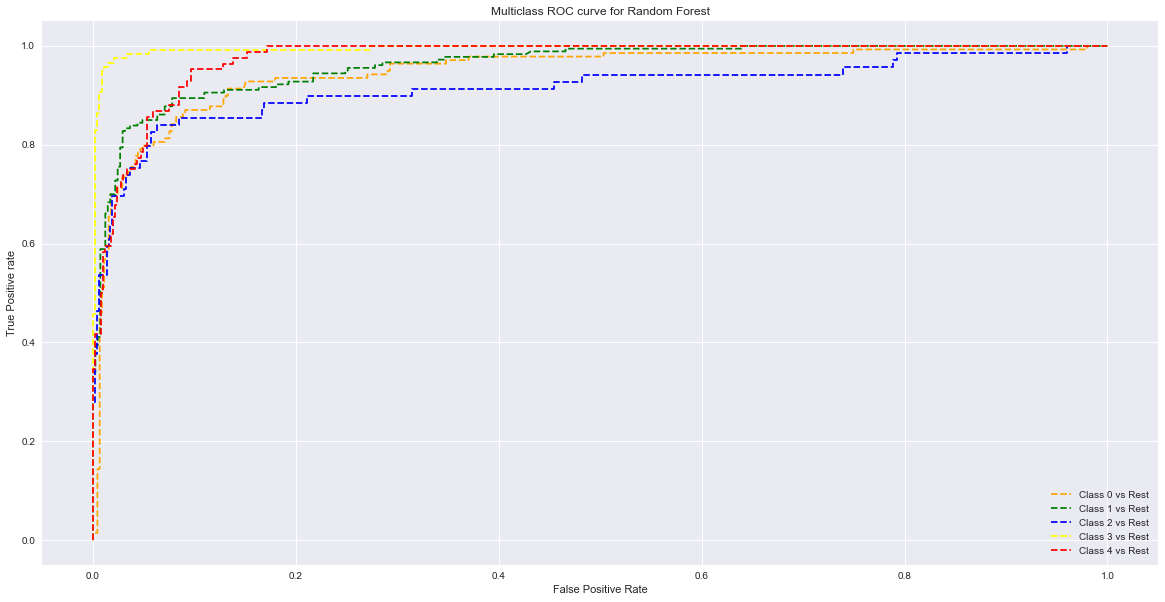

In [39]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for Random Forest',dpi=500);    

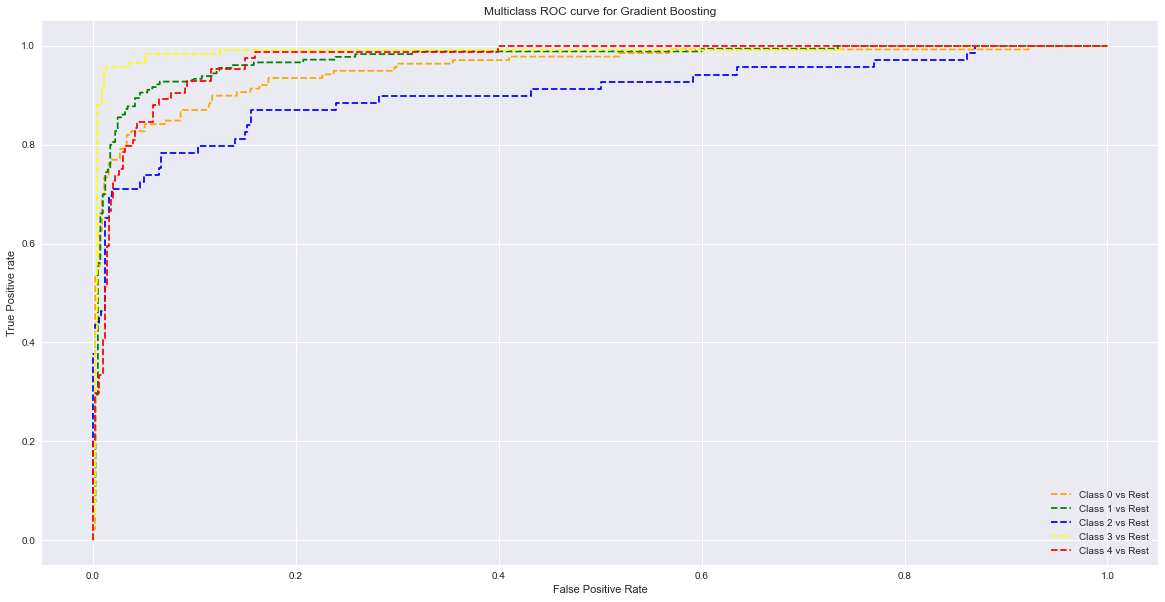

In [40]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(GradientBoostingClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for Gradient Boosting',dpi=500);    

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
classifier=GradientBoostingClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("Gradient_Boost_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('GradientBoostingClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

Gradient_Boost_training time: 167.176 s
GradientBoostingClassifier: 0.8322033898305085
[[110   7  11   4   7]
 [ 12 158   7   0   3]
 [  3   7  49   2   8]
 [  1   1   7 109   0]
 [  8   4   7   0  65]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       139
           1       0.89      0.88      0.89       180
           2       0.60      0.71      0.65        69
           3       0.95      0.92      0.94       118
           4       0.78      0.77      0.78        84

    accuracy                           0.83       590
   macro avg       0.81      0.82      0.81       590
weighted avg       0.84      0.83      0.83       590

Accuracy score (training): 0.987
Accuracy score (test): 0.832


In [43]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred_lgbm = model.predict(X_test)
print('LGBMClassifier:',accuracy_score(y_test,y_pred_lgbm))
print(confusion_matrix(y_test,y_pred_lgbm))
print(classification_report(y_test,y_pred_lgbm))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

LGBMClassifier: 0.8728813559322034
[[120   3   5   3   8]
 [  9 157   5   0   9]
 [  2   5  54   2   6]
 [  1   0   4 113   0]
 [  6   5   2   0  71]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       139
           1       0.92      0.87      0.90       180
           2       0.77      0.78      0.78        69
           3       0.96      0.96      0.96       118
           4       0.76      0.85      0.80        84

    accuracy                           0.87       590
   macro avg       0.86      0.86      0.86       590
weighted avg       0.88      0.87      0.87       590

Accuracy score (training): 0.987
Accuracy score (test): 0.832


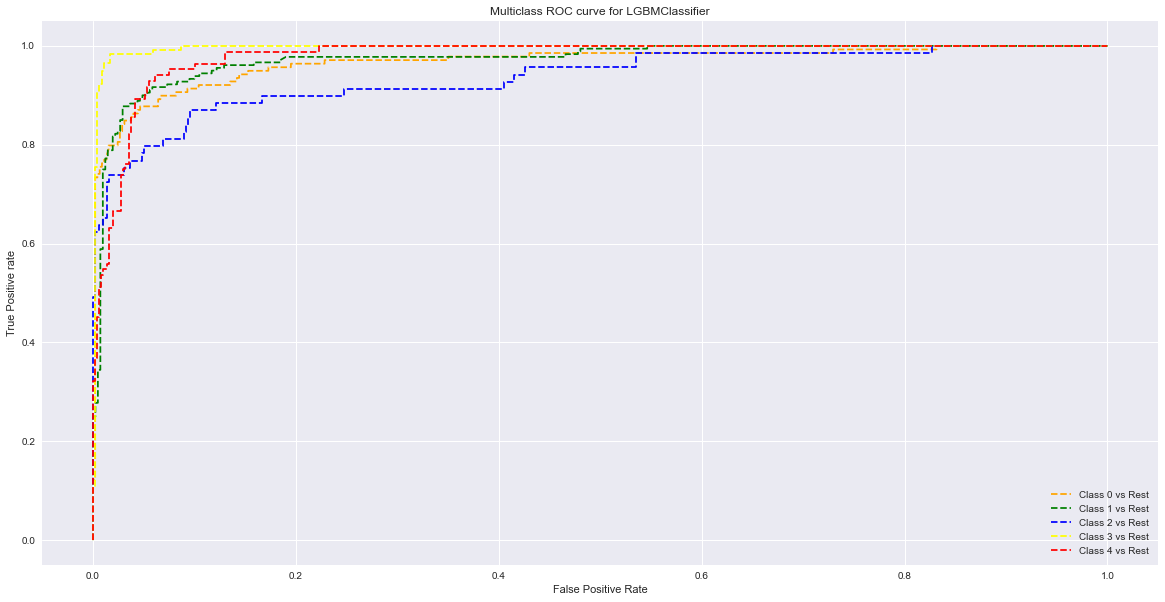

In [44]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(LGBMClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for LGBMClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for LGBMClassifier',dpi=500);    

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=MultinomialNB()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("MultinomialNB_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print(accuracy_score(y_test,y_pred))
print('MultinomialNB:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

MultinomialNB_training time: 0.017 s
0.7694915254237288
MultinomialNB: 0.7694915254237288
[[116  12   5   3   3]
 [ 28 140   1   7   4]
 [  5  11  48   4   1]
 [  0   0   3 115   0]
 [ 20  15  13   1  35]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       139
           1       0.79      0.78      0.78       180
           2       0.69      0.70      0.69        69
           3       0.88      0.97      0.93       118
           4       0.81      0.42      0.55        84

    accuracy                           0.77       590
   macro avg       0.77      0.74      0.74       590
weighted avg       0.77      0.77      0.76       590

Accuracy score (training): 0.784
Accuracy score (test): 0.769


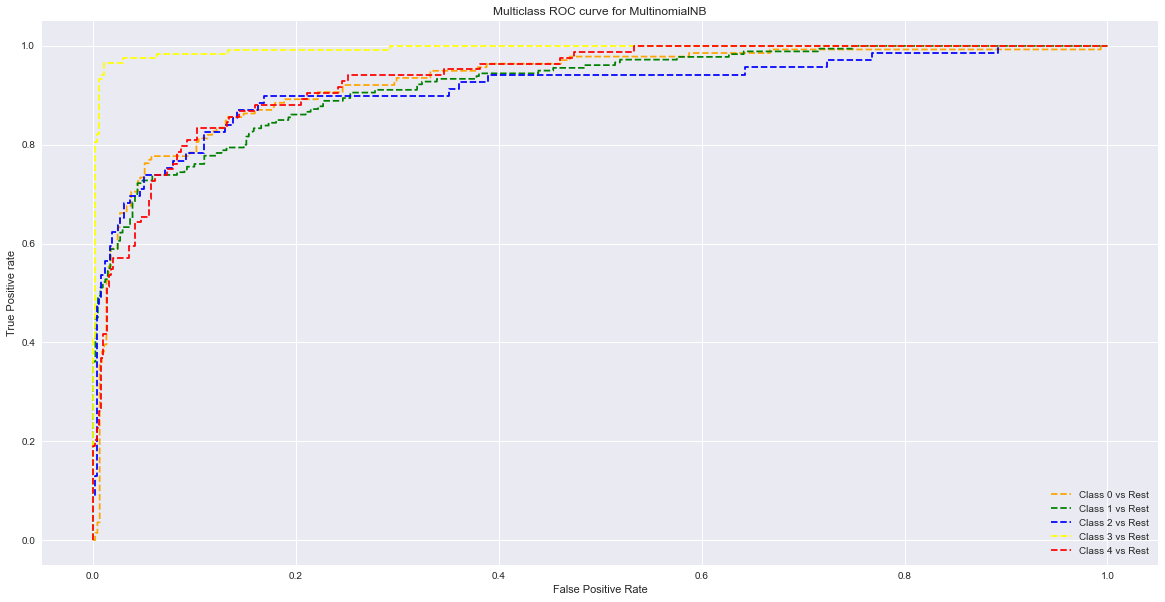

In [46]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for MultinomialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for MultinomialNB',dpi=500);    

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=LogisticRegression()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("Logistic_Regression_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('LogisticRegression:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

Logistic_Regression_training time: 0.515 s
LogisticRegression: 0.8355932203389831
[[117   6   5   3   8]
 [ 19 149   5   0   7]
 [  5   5  54   2   3]
 [  0   0   4 114   0]
 [ 10   7   8   0  59]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       139
           1       0.89      0.83      0.86       180
           2       0.71      0.78      0.74        69
           3       0.96      0.97      0.96       118
           4       0.77      0.70      0.73        84

    accuracy                           0.84       590
   macro avg       0.82      0.82      0.82       590
weighted avg       0.84      0.84      0.84       590

Accuracy score (training): 0.899
Accuracy score (test): 0.836


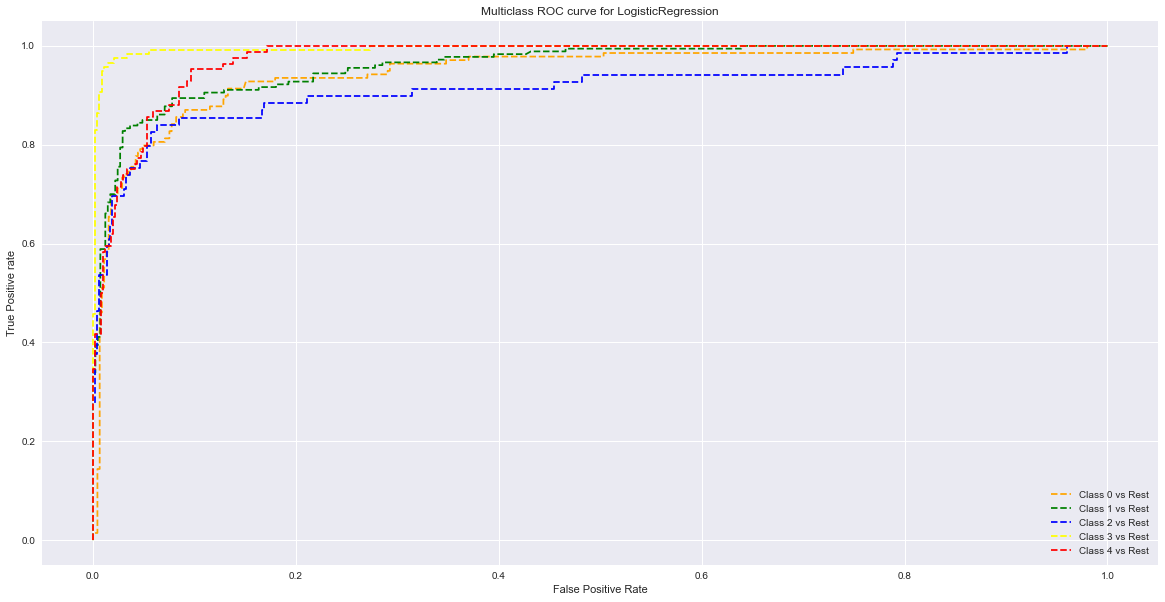

In [48]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for LogisticRegression',dpi=500);    

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=SVC()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("SVC_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('SVC:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

SVC_training time: 5.759 s
SVC: 0.8559322033898306
[[119   4   7   3   6]
 [ 20 148   4   1   7]
 [  6   3  57   2   1]
 [  0   1   3 113   1]
 [  9   2   5   0  68]]
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       139
           1       0.94      0.82      0.88       180
           2       0.75      0.83      0.79        69
           3       0.95      0.96      0.95       118
           4       0.82      0.81      0.81        84

    accuracy                           0.86       590
   macro avg       0.85      0.85      0.85       590
weighted avg       0.86      0.86      0.86       590

Accuracy score (training): 0.960
Accuracy score (test): 0.856


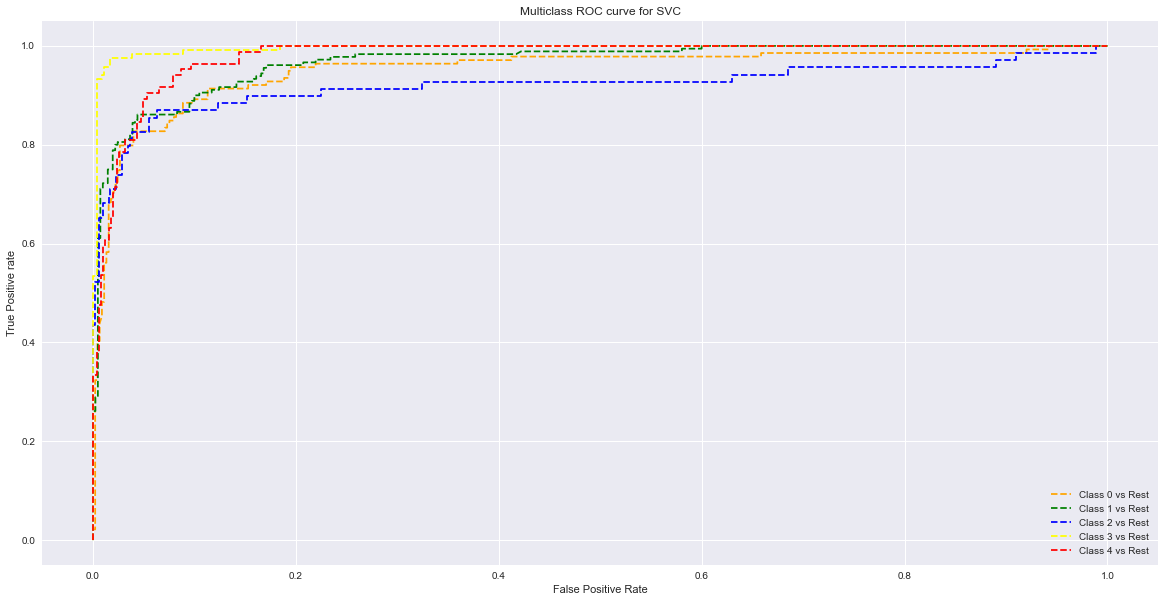

In [51]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(SVC(probability=True))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for SVC',dpi=500);    

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=DecisionTreeClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("Decision_tree_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

Decision_tree_training time: 1.022 s
0.7661016949152543
[[101  10  14   4  10]
 [ 11 146  12   1  10]
 [  6   4  48   5   6]
 [  1   1   6 108   2]
 [ 10  10  15   0  49]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       139
           1       0.85      0.81      0.83       180
           2       0.51      0.70      0.59        69
           3       0.92      0.92      0.92       118
           4       0.64      0.58      0.61        84

    accuracy                           0.77       590
   macro avg       0.74      0.75      0.74       590
weighted avg       0.78      0.77      0.77       590

Accuracy score (training): 0.997
Accuracy score (test): 0.766


In [63]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(DecisionTreeClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for DecisionTreeClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for DecisionTreeClassifier',dpi=500);    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:422: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=KNeighborsClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("KNN_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('KNeighborsclassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

KNN_training time: 0.009 s
KNeighborsclassifier: 0.6491525423728813
[[127  10   1   1   0]
 [ 48 127   3   1   1]
 [ 47   3  18   1   0]
 [ 17   2   1  98   0]
 [ 63   7   1   0  13]]
              precision    recall  f1-score   support

           0       0.42      0.91      0.58       139
           1       0.85      0.71      0.77       180
           2       0.75      0.26      0.39        69
           3       0.97      0.83      0.89       118
           4       0.93      0.15      0.27        84

    accuracy                           0.65       590
   macro avg       0.78      0.57      0.58       590
weighted avg       0.77      0.65      0.63       590

Accuracy score (training): 0.713
Accuracy score (test): 0.649


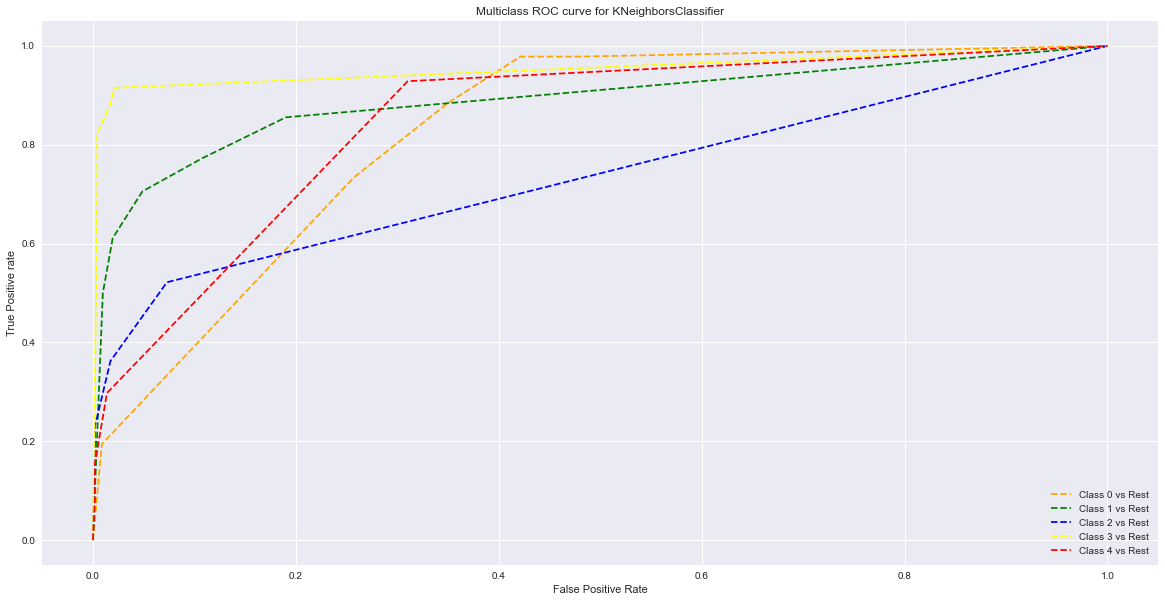

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for KNeighborsClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for KNeighborsClassifier',dpi=500);    

In [56]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier=SGDClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("SGDC_training time:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('SGDClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

SGDC_training time: 1.166 s
SGDClassifier: 0.8355932203389831
[[111   7   7   4  10]
 [ 11 150   6   1  12]
 [  2   5  54   2   6]
 [  0   0   3 113   2]
 [  7   5   7   0  65]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       139
           1       0.90      0.83      0.86       180
           2       0.70      0.78      0.74        69
           3       0.94      0.96      0.95       118
           4       0.68      0.77      0.73        84

    accuracy                           0.84       590
   macro avg       0.81      0.83      0.82       590
weighted avg       0.84      0.84      0.84       590

Accuracy score (training): 0.962
Accuracy score (test): 0.836


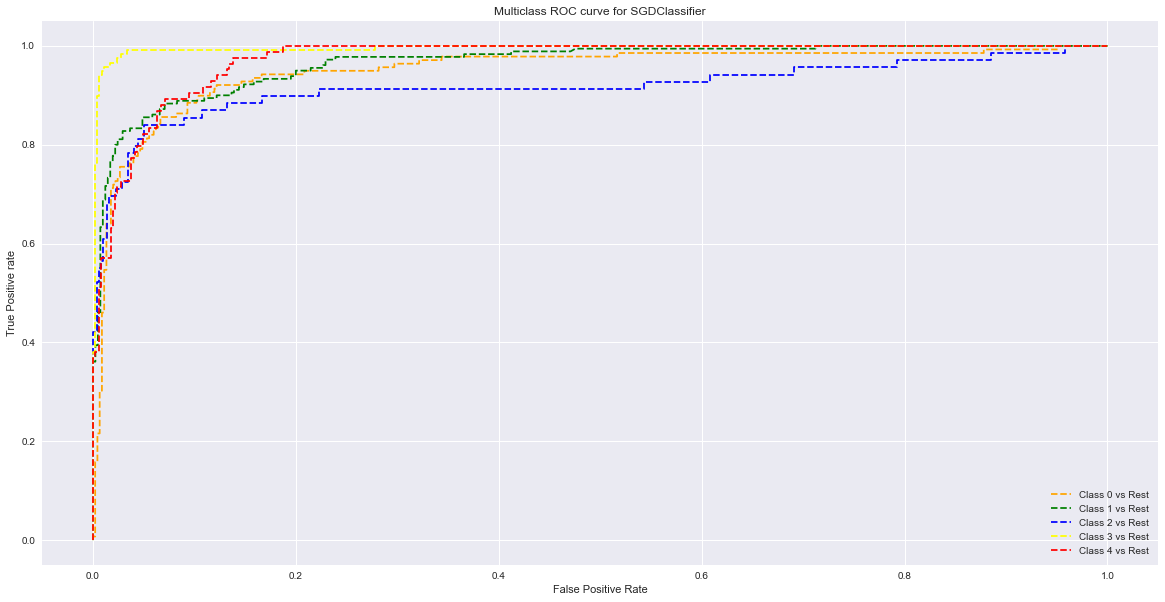

In [61]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(SGDClassifier(loss='log'))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for SGDClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for SGDClassifier',dpi=500);    

In [58]:
from sklearn.ensemble import AdaBoostClassifier
classifier=AdaBoostClassifier()
start = time.time()
classifier.fit(X_train,y_train)
end = time.time()
print ("AdaBoost:", round(end-start, 3), "s")
y_pred=classifier.predict(X_test)
print('AdaBoostClassifier:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(classifier.score(X_test, y_test)))

AdaBoost: 8.565 s
AdaBoostClassifier: 0.6779661016949152
[[ 80  32  11   2  14]
 [ 12 124  25   0  19]
 [  1   9  52   2   5]
 [  0   0  11 107   0]
 [ 10  13  24   0  37]]
              precision    recall  f1-score   support

           0       0.78      0.58      0.66       139
           1       0.70      0.69      0.69       180
           2       0.42      0.75      0.54        69
           3       0.96      0.91      0.93       118
           4       0.49      0.44      0.47        84

    accuracy                           0.68       590
   macro avg       0.67      0.67      0.66       590
weighted avg       0.71      0.68      0.68       590

Accuracy score (training): 0.730
Accuracy score (test): 0.678


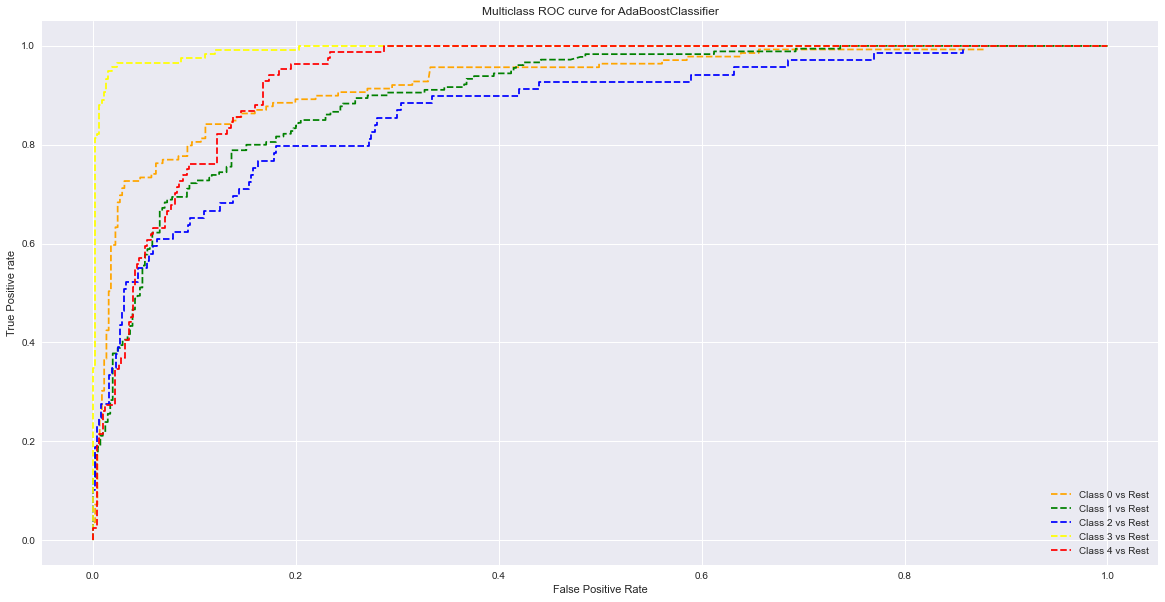

In [59]:
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# fit model
clf = OneVsRestClassifier(AdaBoostClassifier())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve for AdaBoostClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC for AdaBoostClassifier',dpi=500);    